<a href="https://colab.research.google.com/github/stefanogiagu/DL2023/blob/main/handson/Classical_AE_MNIST_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple Convolutional AE for anomaly detection of MNIST digits

DL tool: pytorch

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.0.1+cu118
0.15.2+cu118


In [2]:
# read minist from openml
from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int)

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


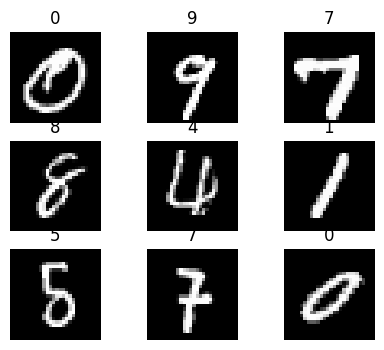

In [3]:
# plot 9 images ranomly chosen from the dataset
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [4]:
# normalize images in [0,1]

X = images / 255.

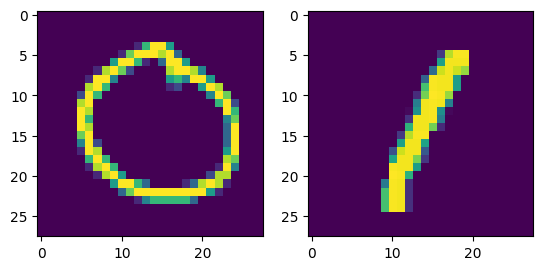

In [7]:
# extract MNIST 0 and 1 digits

# digit 0 images  represent normal data
# digit 1 images represent anomalous data

mnist0 = X[labels==0]
mnist1 = X[labels==1]

plt.subplot(1,2,1)
plt.imshow(mnist0[7].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(mnist1[11].reshape((28,28)))

In [9]:
# convert numpy arrays in torch tensor

X0 = torch.Tensor(mnist0).float()
X1 = torch.Tensor(mnist1).float()

# reshaping tensors from (n,784) to (n,1,28,28)

X0 = X0.view((X0.shape[0],1,28,28))
X1 = X1.view((X1.shape[0],1,28,28))

from torch.utils.data import TensorDataset, DataLoader

X0_dataset = TensorDataset(X0, X0)

ds0, ds0t = torch.utils.data.random_split(X0_dataset, [int(0.9*len(X0_dataset)), len(X0_dataset) - int(0.9*len(X0_dataset))])

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

ds0_dl = DataLoader(ds0, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
ds0t_dl = DataLoader(ds0t, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

ds1 = TensorDataset(X1, X1)
ds1_dl = DataLoader(ds1, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

In [10]:
if torch.cuda.is_available():
  print('# of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of available GPUs:  1
Tesla T4
Computation device: cuda



### AE architecture

a conolvutional AE with a 2 conv2d layers (kernL-size 4, stride 2, and a symmetrical decoder based on ConvTranspose2D. Latent space made by a dense layer. Sigmoid output.

In [11]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1)

        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_z = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1) #flatten

        z = self.fc_z(x)

        return z

In [12]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [13]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)

        return x_recon

In [14]:
# Training


# instantiate the model

hidden_channels = 64
latent_dim = 2 #latent space dimension

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy (you can use BCELoss from pytorch directly)
def vae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784))
    return recon_loss

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [15]:
# Training loop

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in ds0_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = vae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 8.4214, train loss: 0.308869
epoch: 2, time(s): 0.3978, train loss: 0.217502
epoch: 3, time(s): 0.4072, train loss: 0.204393
epoch: 4, time(s): 0.4002, train loss: 0.198406
epoch: 5, time(s): 0.3969, train loss: 0.194711
epoch: 6, time(s): 0.4136, train loss: 0.192924
epoch: 7, time(s): 0.4054, train loss: 0.191398
epoch: 8, time(s): 0.4053, train loss: 0.190320
epoch: 9, time(s): 0.4444, train loss: 0.189202
epoch: 10, time(s): 0.5423, train loss: 0.188571
epoch: 11, time(s): 0.5884, train loss: 0.187708
epoch: 12, time(s): 0.5614, train loss: 0.187042
epoch: 13, time(s): 0.5334, train loss: 0.186331
epoch: 14, time(s): 0.4038, train loss: 0.185227
epoch: 15, time(s): 0.4080, train loss: 0.184376
epoch: 16, time(s): 0.4036, train loss: 0.183810
epoch: 17, time(s): 0.4101, train loss: 0.182987
epoch: 18, time(s): 0.4075, train loss: 0.182398
epoch: 19, time(s): 0.4093, train loss: 0.181676
epoch: 20, time(s): 0.4090, train loss: 0.181340
epoch: 21, time(s): 0.4071, t

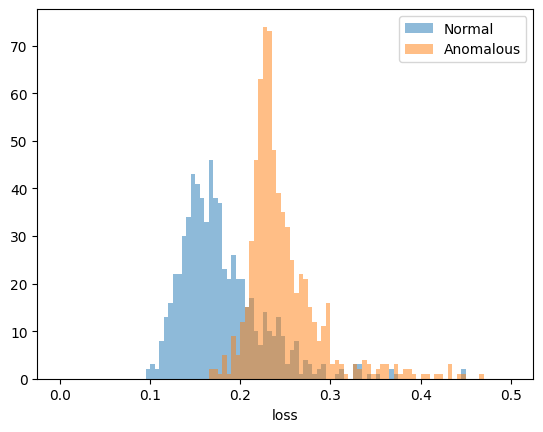

In [17]:
# Plot distribution of the BCELoss for test 0 and 1 events
# we use the reconstruction loss as an anomaly measure (you may think to others anmaly measures, for example
# based on the latent representation)

model_ae.eval()

ev0_loss = []
ev1_loss = []

with torch.no_grad():
  for xb, _ in ds0t_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev0_loss.append(loss.item())

  for xb, _ in ds1_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev1_loss.append(loss.item())

plt.hist(ev0_loss, bins=100, range=[0,0.5], label='Normal', alpha=0.5)
plt.hist(ev1_loss[:len(ev0_loss)], bins=100, range=[0,0.5], label='Anomalous', alpha=0.5)
plt.xlabel("loss")
plt.legend()
plt.show()